### <span style="color:rgb(92,29,79)">Optimization for Machine Learning</span>

### <span style="color:rgb(92,29,79)">M2 MIAGE ID Apprentissage, 2024-2025</span>


# <span style="color:rgb(92,29,79)">Lab session 1 - Gradient descent and convex optimization (with solutions)</span>

Lecture notes for this course are available [here](https://www.lamsade.dauphine.fr/~croyer/ensdocs/OID/PolyOID.pdf).

This Jupyter notebook can be obtained [here](https://www.lamsade.dauphine.fr/~croyer/ensdocs/OID/LabOID01solutions.zip).


For any comment regarding this notebook (including typos), please send an email to:  **clement.royer@lamsade.dauphine.fr**.

#### <span style="color:rgb(92,29,79)">Preliminary remarks</span>

- This notebook and the subsequent ones used in this course mix Python code and text/LaTeX blocks. They can be run offline on any computer where Python and Jupyter are installed, or online using Google Colab (requires a Google account).

- All code blocks from this notebook are meant to be run in the order that they are given. In particular, the first block below must be run first in order to import the necessary toolboxes.

- All the notebooks from this course rely on Python and the NumPy library. A basic yet very useful tutorial on NumPy is freely available
[here](https://sebastianraschka.com/pdf/books/dlb/appendix_f_numpy-intro.pdf).

In [1]:
# Import useful librairies and functions
###############################################

# Plots
%matplotlib inline
import matplotlib.pyplot as plt

from math import sqrt # Square root

# NumPy - Vector and matrix structures
import numpy as np # NumPy library
from numpy.random import multivariate_normal, randn, uniform, choice # Probability distributions

# SciPy - Efficient numerical calculations
from scipy.linalg import norm # Standard norms
from scipy.linalg import toeplitz # Toeplitz matrices
from scipy.linalg import svdvals # Singular value decomposition (recall Lecture 2!)
from scipy.optimize import check_grad # Numerical check of derivatives
from scipy.optimize import fmin_l_bfgs_b # An efficient minimization routine in moderate dimensions

#### <span style="color:rgb(92,29,79)">Useful NumPy routines (check the documentation for more details)</span>

* *transpose* Transpose of a matrix (i.e. a two-dimensional NumPy array), also works for vectors. If X is the variable, X.T also works.
* *matmul* Matrix-matrix product (dimensions permitting). Warning: A * B returns the componentwise product.
* *dot* Matrix-vector product (dimensions permitting), can also be used as inner/scalar product between two vectors of same length.
* *np.ones((m,n))* m-by-n matrix with all components being equal to 1. 
* *np.zeros((m,n))* m-by-n matrix with all components being equal to 0.
* *np.identity(n)*  n-by-n identity matrix (ones on the diagonal, zeroes everywhere else).
* *np.pi* $\pi$.
* *np.inf* Infinite number representation.
* *np.log* Logarithm operator applied componentwise to a NumPy array.
* *np.exp* Exponential operator applied componentwise to a NumPy array.
* *np.sum* Sums the components of NumPy array (for matrices, sums along one dimension)
* *np.maximum(u,v)* Returns a NumPy array with coordinates $max(u_i,v_i)$, where $u_i$ and $v_i$ are the coordinates of $u$ and $v$, respectively.;
* *np.concatenate* gathers NumPy arrays (vectors or matrices) with compatibles dimensions.
* For any NumPy array *a*, *a.shape* returns the dimension(s) of this array (useful to build another array with the same dimensions).

# <span style="color:rgb(92,29,79)">Introduction</span>

In this session, we illustrate the behavior of gradient descent on linear least squares, arguably the most classical nonlinear smooth optimization problem. The simple form of this problem serves our purpose of illustrating the behavior of gradient descent. Note that this problem is convex.

# <span style="color:rgb(92,29,79)">1. Preliminary questions</span>

### <span style="color:rgb(92,29,79)">Question 1</span>

*Let $f: \mathbb{R}^d \rightarrow \mathbb{R}$ be a $\mathcal{C}^1$ convex function. Give a condition that caracterize the global minima of $f$.*

#### <span style="color:rgb(92,29,79)">Answer to question 1</span>

The set of global minima for $f$ corresponds to the set of vectors $\mathbf{w} \in \mathbb{R}^d$ such that
$$
    \nabla f(\mathbf{w}) = \mathbf{0}.
$$

### <span style="color:rgb(92,29,79)">Question 2</span>

*Give an example for a convex function from $\mathbb{R}^d$ to $\mathbb{R}$ that is $\mathcal{C}^1$ and has no global minimum.*

#### <span style="color:rgb(92,29,79)">Answer to question 2</span> 

The function $\mathbf{w} \mapsto \mathbf{a}^T\mathbf{w}+\mathbf{b}$ is convex, but unbounded if $\mathbf{a}$ is a nonzero vector. In that case, it does not have a minimum.

# <span style="color:rgb(92,29,79)">2. Linear regression</span>

## <span style="color:rgb(92,29,79)">2.1. Problem data</span>

Consider data under the form $\{(\mathbf{x}_i,y_i)\}_{i=1,\dots,n}$, where $\mathbf{x}_i \in \mathbb{R}^d$ and $y_i \in \mathbb{R}$. We gather this data under the form of

- a feature matrix $\mathbf{X} \in \mathbb{R}^{n \times d}$;
- a vector of labels $\mathbf{y} \in \mathbb{R}^n$. 

The procedure below generates the problem data. **This code is not fundamental to this course, and students will not be expected to write similar pieces of code.**

In [2]:
# Generate data for linear least squares. This code is based on a generator proposed by Alexandre Gramfort (INRIA).
def simu_linreg(wtruth, n, std=1., corr=0.5):
    """
    Generation of data from a linear trend corrupted by Gaussian noise. 
    
    Inputs
    ----------
    wtruth: np.ndarray, shape=(d,)
        Ground truth coefficients
    
    n: int
        Sample size
    
    std: float, default=1.
        Standard deviation for the noise

    corr: float, default=0.5
        Correlation for the feature matrix
        
    Outputs
    ------------
    X: Feature matrix
    y: Label vector
    
    """      
    d = wtruth.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    X = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    # Main relationship
    y = X.dot(wtruth) + noise
    return X, y

The data will originate from a linear trend $\mathbf{X}\mathbf{w}_{truth}$ corrupted by additive Gaussian (i.e. standard normal) noise. As seen in class, this is the setup of linear regression, that bears a very close connection with linear least squares.

## <span style="color:rgb(92,29,79)">2.2. Problem formulation</span>

Given the problem data $(\mathbf{X},\mathbf{y})$, we seek $\mathbf{w} \in \mathbb{R}^d$ such that $\mathbf{X} \mathbf{w} -\mathbf{y} \approx 0$.

By assuming (as is the case here) that the observations are corrupted by Gaussian noise, the problem of finding the best linear model that matches our problem data can be formulated as the following linear least squares problem:
$$
    \mathrm{minimize}_{\mathbf{w} \in \mathbb{R}^d} 
    f(\mathbf{w}) := \frac{1}{2 n} \|\mathbf{X} \mathbf{w} - \mathbf{y}\|^2 
    = \frac{1}{2n} \sum_{i=1}^n (\mathbf{x}_i^T \mathbf{w} - y_i)^2.
$$ 

For any $\mathbf{w}$, the gradient of the objective function is given by
$$
    \nabla f(\mathbf{w}) =\frac{1}{n}\mathbf{X}^T (\mathbf{X} \mathbf{w} - \mathbf{y}).
$$
Moreover, $\nabla f$ is $L_f$-Lipschitz continuous with $L_f=\frac{\|\mathbf{X}^T \mathbf{X}\|}{n}$. The function $f$ is therefore $\mathcal{C}^{1,1}_{L_f}$.

### <span style="color:rgb(92,29,79)">Question 3</span> 

*Justify that $0$ is a lower bound of $f$ on $\mathbb{R}^d$. Do we necessarily have $0=\mathrm{min}_{\mathbf{w} \in \mathbb{R}^d} f(\mathbf{w})$?*

#### <span style="color:rgb(92,29,79)">Answer to question 3</span> 

Any value less than or equal to $0$ is a *lower bound* on $f$ since $f$ only takes nonnegative values. The value $0$ 
*could be* the optimal value, but this depends on whether there exists a vector $\mathbf{w}^*$ that perfectly interpolates the data, i.e. a vector $\mathbf{w}^*$ such that $\mathbf{X} \mathbf{w}^* = \mathbf{y}$.

## <span style="color:rgb(92,29,79)">2.3. Problem reformulation</span>

Any linear least-squares problem can be rewritten as a *quadratic optimization problem*. In our case, one possible reformulation is
$$
    \mathrm{minimize}_{\mathbf{w} \in \mathbb{R}^d} \frac{1}{2}\mathbf{w}^T \mathbf{A} \mathbf{w} - \mathbf{b}^T \mathbf{w} + c.
$$
where $\mathbf{A} = \tfrac{\mathbf{X}^T \mathbf{X}}{n}$, $\mathbf{b} = \frac{\mathbf{X}^T \mathbf{y}}{n}$ and $c=\frac{\mathbf{y}^T \mathbf{y}}{2 n}$. We thus have $f(\mathbf{w})=\frac{1}{2}\mathbf{w}^T \mathbf{A} \mathbf{w} - \mathbf{b}^T \mathbf{w} + c$ for any $\mathbf{w} \in \mathbb{R}^d$. 

The quadratic function is (in particular) $\mathcal{C}^1$, and its gradient is given by
$$
    \nabla f(\mathbf{w}) 
    = \mathbf{A} \mathbf{w} - \mathbf{b} 
    = \frac{1}{n}\mathbf{X}^T \left(  \mathbf{X} \mathbf{w} - \mathbf{y}\right).
$$
Moreover, for any $(\mathbf{v},\mathbf{w}) \in (\mathbb{R}^d)^2$, we have
$$
    \| \nabla f(\mathbf{v}) - \nabla f(\mathbf{w}) \| 
    \le \| \mathbf{A} (\mathbf{v}-\mathbf{w}) \| 
    \le \|\mathbf{A} \| \|\mathbf{v} -\mathbf{w}\|,
$$
where the last inequality follows from the definition of the norm $\|\mathbf{A}\| = \max_{\mathbf{u} \neq 0} \tfrac{\|\mathbf{A}\mathbf{u}\|}{\|\mathbf{u}\|}$. As a result, the function $f$ is $\mathcal{C}^{1,1}_{\|\mathbf{A}\|}$ with $\|\mathbf{A}\| = \tfrac{1}{n}\|\mathbf{X}^T \mathbf{X}\|$ being a Lipschitz constant for the gradient.

## <span style="color:rgb(92,29,79)">2.4 Python class for linear regression</span>


### <span style="color:rgb(92,29,79)">Question 4: Implementation</span>

*The code above will be used thereafter to encode linear regression problems. Using the above formulae, fill out the missing parts of the code related to $f(\mathbf{w})$ and $\nabla f(\mathbf{w})$.*  

*Reminder:* Given a NumPy array X, X.dot(v) corresponds to the matrix-vector product $X v$ if $X$ is a matrix, or the scalar product $X^T v$ if X is a vector. The command X.T returns $X^T$.

In [3]:
# Python class for linear regression
class LinReg(object):
    '''
        Linear regression problems under the form of linear least squares.
        
        Attributes:
            X: Two-dimensional array representing a feature matrix
            y: One-dimensional array representing a label vector
            n,d: Problem dimensions (X is n x d, y is n by 1)
            
        Methods:
            fun: Computes the value of the objective function for linear least squares.
            grad: Computes the value of the gradient for linear least squares.
            lipgrad: Computes the value of the Lipschitz constant for the gradient.
    '''     

    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.n, self.d = X.shape
    
    # Objective function
    def fun(self, w):
        ## ADD THE FORMULA FOR THE OBJECTIVE VALUE (1 LINE OF CODE)
        return norm(self.X.dot(w) - self.y) ** 2 / (2. * self.n) 
    
    # Gradient
    def grad(self, w):
        ## ADD THE FORMULA FOR THE GRADIENT OF THE FUNCTION (1 LINE OF CODE)
        return self.X.T.dot(self.X.dot(w) - self.y) / self.n 

    # Lipschitz constant for the gradient
    def lipgrad(self):
        L = norm(self.X, ord=2) ** 2 / self.n # Cheaper than compute ||X^T X|| directly
        return L 
    
    # Strong convexity constant (absent from the first version of the notebook)
    def cvxval(self):
        s = svdvals(self.X)
        return min(s)**2 / self.n 

### <span style="color:rgb(92,29,79)">Question 5: Testing</span>

*Check the correctness of the implementation above by generating a problem instance. The auxiliary function* check_grad, *that compares a code for a function and a code for its derivative, should return a value of order $10^{-6}$*.

In [4]:
# Dimensions 
d = 50
n = 1000
idx = np.arange(d)


# Ground truth vector - The coefficients are decaying exponentially
w_model_truth = (-1)**idx * np.exp(-idx / 10.)

# Generation of the feature matrix and label vector
np.random.seed(1) # Select a random seed for reproducibility
X, y = simu_linreg(w_model_truth, n, std=1., corr=0.1)

# Generate the corresponding problem instance
pblinreg = LinReg(X, y)

# Check the formulae and the consistency between the objective and its gradient 
# If correct, returns a value of order 10^(-6) 
check_grad(pblinreg.fun, pblinreg.grad, np.random.randn(d))

1.151883568737117e-06

## <span style="color:rgb(92,29,79)">2.5 Estimate the minimum</span> 

The problem that we consider here is of relatively small dimension ($d=50,n=1000$), thus it can be solved efficiently using methods that have a higher cost than gradient descent. The code below uses the L-BFGS method to compute a solution that is quite close to a global minimum.

In [5]:
# Use L-BFGS to obtain a good approximation for the minimum

w_init = np.zeros(d)

# Compute an approximate solution for linear regression using L-BFGS
w_min_lin, f_min_lin, _ = fmin_l_bfgs_b(pblinreg.fun, w_init, pblinreg.grad, args=(), pgtol=1e-30, factr =1e-30)
print(f_min_lin)
print(norm(pblinreg.grad(w_min_lin)))

0.4737086058623297
4.814890108412364e-10


In the rest of this notebook, we will use these values as proxys for the actual minimum vector and minimum point. The underlying idea is that those values are target values for our gradient-based techniques. Since an efficient second-order method reaches those values, it is highly unlikely that a first-order method such as gradient descent will compute a better point.

*Note: This consideration illustrates the difficulty of solving a nonlinear optimization problem numerically.*

# <span style="color:rgb(92,29,79)">3. Gradient descent</span>

The descent gradient method applied to a function $f$ is defined by an initial point $\mathbf{w}_0 \in \mathbb{R}^d$ as well as the iteration:
$$
\mathbf{w}_{k+1} = \mathbf{w}_k - \alpha_k \nabla f(\mathbf{w}_k),
$$
where $\alpha_k>0$ is a stepsize chosen for iteration $k$.

### <span style="color:rgb(92,29,79)">Question 6</span>

*Suppose that $f$ is $\mathcal{C}^{1,1}_L$ for a known value $L>0$. What constant stepsize choice can the algorithm use? What does this choice guarantee?*

#### <span style="color:rgb(92,29,79)">Answer to question 6</span>

Provided the value $L$ is known, one can set $\alpha_k=\frac{1}{L}$. Using the fundamental inequality for $\mathcal{C}^{1,1}_L$ functions, we see that such a choice gives
$$
    f(\mathbf{w}_{k+1}) \le f(\mathbf{w}_k) + \nabla f(\mathbf{w}_k)^T (\mathbf{w}_{k+1}-\mathbf{w}_k) 
    + \frac{L}{2}\|\mathbf{w}_{k+1}-\mathbf{w}_k\|^2 = f(\mathbf{w}_k) - \frac{1}{2L}\|\nabla f(\mathbf{w}_k)\|^2,
$$
hence the function value will decrease from $\mathbf{w}_k$ to $\mathbf{w}_{k+1}$ as long as the gradient of $f$ at $\mathbf{w}_k$ is nonzero.

### <span style="color:rgb(92,29,79)">Question 7</span>

When $L$ is unknown, one can compute a suitable stepsize using line search. One classical line-search strategy, called the *Armijo backtracking line search*, consists in testing increasingly smaller values until one is found that satisfies a decrease condition on the objective.

In this notebook we will set $\alpha_k=\alpha \tfrac{1}{2^{j_k}}$, where $\alpha>0$ and $j_k$ is the smallest nonnegative integer such that
$$
f\left(\mathbf{w}_k-\frac{\alpha}{2^{j_k}}\nabla f(\mathbf{w}_k)\right) < f(\mathbf{w}_k) - 0.0001 \frac{\alpha}{2^{j_k}}\|\nabla f(\mathbf{w}_k)\|^2.
$$
holds. If $\mathbf{w}_k$ is not a local minimum, the condition is satisfied as long as $\alpha_k < \frac{1}{2 L}$.

*Compare the cost of a gradient descent iteration with line search to that of a gradient descent iteration with a constant stepsize. What can be the interest of using a line search?*

#### <span style="color:rgb(92,29,79)">Answer to question 7</span>

The Armijo line search requires to evaluate the objective function in order to check whether the decrease condition is satisfied. The function evaluations thus represent an additional cost compared to that of a gradient descent iteration with constant stepsize, where the objective function need not be evaluated. As a result, line-search approaches are only relevant if they provide a better value for the stepsize, that leads to more progress at every iteration and a better algorithmic behavior overall.

*(Note: The GD code below always computes the objective value for future use in convergence plots, but those values are not actually needed except in the case of line search).* 

# <span style="color:rgb(92,29,79)">4. Comparing stepsize rules</span>

### <span style="color:rgb(92,29,79)">Question 8: Implementation</span>

*Fill out the function template below with the gradient descent iteration and three different rules for the stepsize:*

- $\alpha_k = \frac{1}{L}$, *where $L$ is the Lipschitz constant for $\nabla f$ (assumed to be known in that case);*

- $\alpha_k = \frac{\alpha_0}{(k+1)^a}$, where $a>0$ is given as input;

- $\alpha_k$ chosen using the Armijo line search from question 6. In practice, the line search will stop if the decrease condition is satisfied or $\frac{\alpha}{2^{j_k}} < 10^{-10}$.

In [6]:
# Gradient descent
def grad_desc(w0,problem,wopt,stepchoice=0,step0=1, n_iter=1000, verbose=True): 
    """
        An implementation of gradient descent with several stepsize rules.
        
        Inputs:
            w0: Initial point
            problem: Problem structure
                problem.fun(w) Objective value
                problem.grad(w) Gradient
                problem.lipgrad() Lipschitz constant for the gradient
            wopt: Target point for the optimization (approximate optimum computed beforehand)
            stepchoice: Rule for choosing the stepsize (see above)
                0: Constant equal to 1/L where L is a Lipschitz constant for the gradient
                a>0: Decreasing, set to 1/((k+1)**a)
                -1: Armijo line search
            step0: Initial step size (used when stepchoice = 1)
            n_iter: Maximum iteration number
            verbose: Boolean value indicating whether iteration-level information should be displayed.
      
        Outputs:
            w_output: Last iterate of the method
            objvals: History of function values (Numpy array of length n_iter)
            distits: History of distances to the target point (Numpy array of length n_iter)
            ngvals: History of gradient norms (Numpy array of length n_iter)
            
    """
    
    ############
    # Initialization

    # History of function values
    objvals = []
    
    # History of gradient norms
    ngvals = []
    
    # History of distances to the target
    distits = []
    
    # Lipschitz constant
    L = problem.lipgrad()
    
    # Initial value of the incumbent, a.k.a. current iterate
    w = w0.copy()

    # Initialize the iteration count
    k=0    
    
    # Initial function value
    obj = problem.fun(w) 
    objvals.append(obj);
    
    # Initial gradient
    g = problem.grad(w)
    ng = norm(g)
    ngvals.append(ng)
    
    # Distance between the current point and the optimal point
    dist = norm(w-wopt)
    distits.append(dist)

    # Plot initial values 
    if verbose:
        print("Gradient descent:")
        print(' | '.join([name.center(8) for name in ["iter", "fval", "dist","stepsize"]]))
    
    ####################
    # Main loop
    while (k < n_iter):
        
        ###### THIS PART SHOULD BE FILLED WITH THE ACTUAL STEPSIZE CALCULATION AND ITERATION
        
        # 1 - Define the stepsize s based on k (iteration index), L (Lipschitz constant), step0 (initial value)
        # and g (the function)
        if stepchoice==0:
            # Constant stepsize
            s = (1/L)
        elif stepchoice>0:
            # Decreasing stepsize
            s = step0/((k+1)**stepchoice)
        elif stepchoice==-1:
            # Line search (inner while loop)
            s = step0
            while (problem.fun(w-s*g) >= obj - 0.0001*s*(ng**2)) and (s>1e-10):
                s = 0.5*s
        
        # 2 - Perform the gradient descent iteration using the stepsize s and the gradient g
        w[:] = w - s*g
      
            
        ###### NOTHING MORE TO FILL PAST THIS POINT. 
        ###### MAKE SURE THAT w NOW CONTAINS THE NEXT ITERATE AND s THE ASSOCIATED STEPSIZE
        
        
        # Plot relevant information
        if verbose:        
            print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % dist).rjust(8),("%.2e" % s).rjust(8)]))
        
        # Compute values associated with the next iterate
        obj = problem.fun(w)
        objvals.append(obj)
        g = problem.grad(w)
        ng = norm(g)
        ngvals.append(ng)
        dist = norm(w-wopt)
        distits.append(dist)
        
        # Increase iteration counter
        k += 1
    
    # End main loop
    ######################
    
    # Outputs
    w_output = w.copy()
    return w_output, np.array(objvals), np.array(distits), np.array(ngvals)

The next two blocks compare four variants of gradient descent based on different stepsize rules:

- $\alpha_k = \frac{1}{L}$;

- $\alpha_k = \frac{\alpha_0}{k+1}$;

- $\alpha_k = \frac{\alpha_0}{\sqrt{k+1}}$;

- $\alpha_k$ chosen using the Armijo line search.

In all cases, $\alpha_0=1$.

In [7]:
# Run four variants of gradient descent using the same initial point
w0 = np.zeros(d)
w_a, obj_a, ngrad_a,_ = grad_desc(w0,pblinreg,w_min_lin,stepchoice=0,step0=1, n_iter=50)
w_b, obj_b, ngrad_b,_ = grad_desc(w0,pblinreg,w_min_lin,stepchoice=1,step0=1, n_iter=50)
w_c, obj_c, ngrad_c,_ = grad_desc(w0,pblinreg,w_min_lin,stepchoice=0.5,step0=1, n_iter=50)
w_d, obj_d, ngrad_d,_ = grad_desc(w0,pblinreg,w_min_lin,stepchoice=-1,step0=1, n_iter=50)

Gradient descent:
  iter   |   fval   |   dist   | stepsize
       0 | 2.58e+00 | 2.33e+00 | 6.47e-01
       1 | 9.81e-01 | 1.20e+00 | 6.47e-01
       2 | 6.23e-01 | 6.64e-01 | 6.47e-01
       3 | 5.20e-01 | 3.76e-01 | 6.47e-01
       4 | 4.89e-01 | 2.16e-01 | 6.47e-01
       5 | 4.79e-01 | 1.25e-01 | 6.47e-01
       6 | 4.75e-01 | 7.36e-02 | 6.47e-01
       7 | 4.74e-01 | 4.35e-02 | 6.47e-01
       8 | 4.74e-01 | 2.58e-02 | 6.47e-01
       9 | 4.74e-01 | 1.54e-02 | 6.47e-01
      10 | 4.74e-01 | 9.24e-03 | 6.47e-01
      11 | 4.74e-01 | 5.55e-03 | 6.47e-01
      12 | 4.74e-01 | 3.35e-03 | 6.47e-01
      13 | 4.74e-01 | 2.03e-03 | 6.47e-01
      14 | 4.74e-01 | 1.23e-03 | 6.47e-01
      15 | 4.74e-01 | 7.46e-04 | 6.47e-01
      16 | 4.74e-01 | 4.54e-04 | 6.47e-01
      17 | 4.74e-01 | 2.77e-04 | 6.47e-01
      18 | 4.74e-01 | 1.69e-04 | 6.47e-01
      19 | 4.74e-01 | 1.03e-04 | 6.47e-01
      20 | 4.74e-01 | 6.32e-05 | 6.47e-01
      21 | 4.74e-01 | 3.87e-05 | 6.47e-01
      22 | 4.74e

Final objective value for GD - 1/L 0.4737086058623297
Final objective value for GD - 1/(k+1) 0.47483938564753725
Final objective value for GD - 1/(sqrt(k+1)) 0.47370861692926497
Final objective value for GD - Line Search 0.4737086058623297


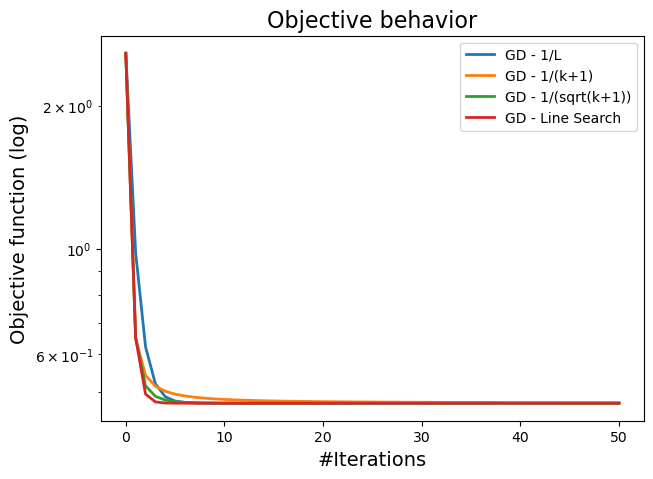

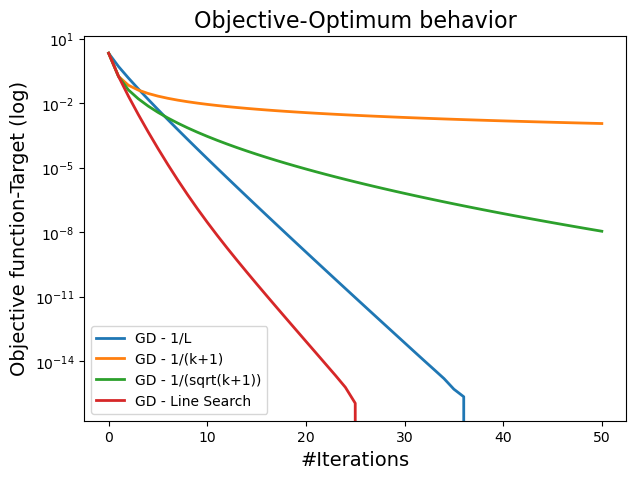

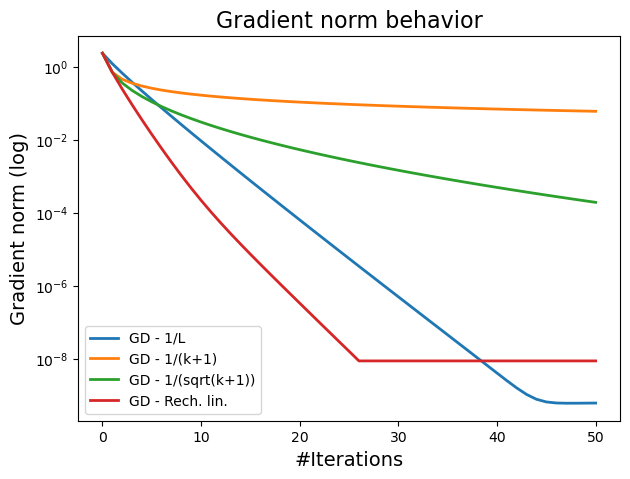

In [8]:
# Plotting the behavior of all methods

# Best/Final objective value
print("Final objective value for GD - 1/L",obj_a[-1])
print("Final objective value for GD - 1/(k+1)",obj_b[-1])
print("Final objective value for GD - 1/(sqrt(k+1))",obj_c[-1])
print("Final objective value for GD - Line Search",obj_d[-1])

# We begin by plotting the change in the function value (in log scale) as a function of the iteration number
plt.figure(figsize=(7, 5))
plt.semilogy(obj_a, label="GD - 1/L", lw=2)
plt.semilogy(obj_b, label="GD - 1/(k+1)", lw=2)
plt.semilogy(obj_c, label="GD - 1/(sqrt(k+1))", lw=2)
plt.semilogy(obj_d, label="GD - Line Search", lw=2)
plt.title("Objective behavior", fontsize=16)
plt.xlabel("#Iterations", fontsize=14)
plt.ylabel("Objective function (log)", fontsize=14)
plt.legend()

# We can also plot the change in function value relatively to the target value 
# Note: In log scale, the values f(w)-vmin close to 0 do not appear


#### Plot the behavior of all four methods in terms of relative objective value
plt.figure(figsize=(7, 5))
plt.semilogy(obj_a-f_min_lin, label="GD - 1/L", lw=2)
plt.semilogy(obj_b-f_min_lin, label="GD - 1/(k+1)", lw=2)
plt.semilogy(obj_c-f_min_lin, label="GD - 1/(sqrt(k+1))", lw=2)
plt.semilogy(obj_d-f_min_lin, label="GD - Line Search", lw=2)
plt.title("Objective-Optimum behavior", fontsize=16)
plt.xlabel("#Iterations", fontsize=14)
plt.ylabel("Objective function-Target (log)", fontsize=14)
plt.legend()

#### Plot the behavior of all four methods in terms of gradient norm
plt.figure(figsize=(7, 5))
plt.semilogy(ngrad_a, label="GD - 1/L", lw=2)
plt.semilogy(ngrad_b , label="GD - 1/(k+1)", lw=2)
plt.semilogy(ngrad_c, label="GD - 1/(sqrt(k+1))", lw=2)
plt.semilogy(ngrad_d, label="GD - Rech. lin.", lw=2)
plt.title("Gradient norm behavior", fontsize=16)
plt.xlabel("#Iterations", fontsize=14)
plt.ylabel("Gradient norm (log)", fontsize=14)
plt.legend()

### <span style="color:rgb(92,29,79)">Question 9</span>

*Consider the objective function plots above.*

1) *How can you explain that the variant $\tfrac{1}{k+1}$ leads to a very slow decrease in the function value? Why is this decrease slower than that of the $\tfrac{1}{\sqrt{k+1}}$ variant?*

2) *The line-search variant appears to outperform the fixed stepsize variant in that the function value decreases faster using the former. But what underlying cost of line search is not accounted for in these plots? How would you account for it?*

#### <span style="color:rgb(92,29,79)">Answers to question 9</span>

1) The sequence $\left\{\tfrac{1}{k+1}\right\}_k$ is a decreasing sequence, hence the method takes smaller and smaller steps as the iteration count increases. Even though these steps lead to a decrease in function value, this decrease is small because the steps that are taken are small in norm (small gradient norm+small stepsize). This explains why the method appears to converge, but rather slowly. This trend is less visible for the $\tfrac{1}{\sqrt{k+1}}$ variant, because thestepsize sequence $\left\{\tfrac{1}{\sqrt{k+1}}\right\}_k$ converges to $0$ at a slower rate than $\left\{\tfrac{1}{k+1}\right\}_k$.

2) The above plots do not account for the fact that an iteration of line search may require multiple function evaluations. A better plot in this regard would have the number of function evaluations on the x-axis.

### <span style="color:rgb(92,29,79)">Question 10</span>

*Consider now the gradient norm plot.*

1) *The horizontal lines for the line-search variant correspond to the method not making anymore progress past iteration 25. Algorithmically, how would you observe that using the iteration output of the gradient descent method?*

2) *Suppose that we only have a very limited budget of 5 iterations and cannot perform line search. On our problem, how can you explain that the decreasing stepsizes work better than the fixed stepsize variant?*

#### <span style="color:rgb(92,29,79)">Answers to question 10</span>

1) The iteration output of the method shows both the function value and the gradient norm not moving starting from iteration 25. This behavior is called stalling: the stepsizes that are computed through line search are below our threshold, and therefore the method no longer makes meaningful changes in the parameters.

2) If we restrict ourselves to 5 iterations, the decreasing stepsize variants decrease the gradient norm and the function value more quickly. For the very first iterations, this behavior can be partially explained by the fact that those methods take longer steps than the fixed stepsize variant (e.g. 1 vs 0.6 for the first iteration). Those steps lead to a better point, which in turns puts them in good position for the next iteration. Eventually, however, the decreasing stepsizes go significantly below the $1/L$ threshold, and the constant stepsize choice leads to more improvement on the long run.

# <span style="color:rgb(92,29,79)">5. Acceleration (updated version)</span>

In this section, we will apply several accelerated gradient techniques on our convex problem of interest. 

## <span style="color:rgb(92,29,79)">5.1 Algorithms</span>

We describe here the algorithms that we will use when applied to a convex, $\mathcal{C}^{1,1}_L$ function $f$.

The simplest variant of gradient descent based on acceleration is the *heavy-ball* method due to Polyak. Given $\mathbf{w}_0 \in \mathbb{R}^d$ and $\mathbf{w}_{-1}=\mathbf{w}_0$, the $k$th iteration of the heavy-ball method can be written as follows:
$$
    w_{k+1} = \mathbf{w}_k - \alpha_k \nabla f(\mathbf{w}_k) + \beta_k (\mathbf{w}_k-\mathbf{w}_{k-1}) 
    \qquad \forall k \ge 0,
$$
where $\alpha_k >0$ and $\beta_k >0$. In this notebook, we will choose these parameters to be constant.

We consider here the **accelerated gradient method** (also called Nesterov's method) written under the form of a double recursion.

Starting from $\mathbf{z}_0=\mathbf{w}_0,t_0=0$, the method generates two vector sequences
$\{\mathbf{w}_{k},\mathbf{z}_k\}$ through the following recursion:
$$
    \left\{ 
        \begin{array}{lll}
        \mathbf{w}_{k+1} &= &\mathbf{z}_k - \alpha_k \nabla f(\mathbf{z}_k) \\
        \mathbf{z}_{k+1} &= &\mathbf{w}_{k+1} + \beta_{k+1}(\mathbf{w}_{k+1}-\mathbf{w}_k).
        \end{array}
    \right.
$$
In this recursion, the value $\alpha_k>0$ is a stepsize. For an arbitrary convex function, the $\{\beta_k\}$ sequence is computed via the following formula:
$$
    t_0 = 0,  \quad \forall k \ge 0, 
    \left\{ 
        \begin{array}{lll} 
            t_{k+1} &= &\tfrac{1}{2} (1+ \sqrt{1+4 t_{k-1}^2}), \\ 
            \beta_k &= &\frac{t_k-1}{t_{k+1}},
         \end{array}
     \right.
$$
while for a $\mu$-strongly convex function, $\beta_k$ is chosen as $\frac{\sqrt{L}-\sqrt{\mu}}{\sqrt{L}+\sqrt{\mu}}$.

## <span style="color:rgb(92,29,79)">5.2 Accelerated gradient VS gradient descent</span>

### <span style="color:rgb(92,29,79)">Question 11: Implementation</span>

*Fill out the code below to encode the two variants of Nesterov's algorithm (for convex and for strongly convex problems). The notations of Section 5.1 should be followed.*

In [10]:
# Implementation of accelerated gradient techniques
def ag(w_0,problem,wopt,step,beta='None',n_iter=100,verbose=False): 
    """
        A generic code for the accelerated gradient approach by Nesterov.
        
        Inputs
            w0: Initial point
            problem: Structure representing the problem at hand
                problem.fun(w) returns the value of the objective function at w
                problem.grad(w) returns the value of the gradient at w
                problem.lipgrad() returns a Lipschitz constant for the gradient
                problem.cvxval() returns a strong convexity constant
            wopt: Target point for the optimization (approximate optimum computed beforehand)
            step: Stepsize (taken to be constant for simplicity)
            beta: Momentum parameter
                'None': Predefined choice for the convex case
                Real value: Fixed value (strongly convex case)
            n_iter: Maximum number of iterations
            verbose: Boolean indicating whether information about the iterations should be displayed
      
        Outputs
            w_output: Final iterate of the method
            objvals: History of function values (Numpy array of length n_iter)
            distits: History of distances to the target point (Numpy array of length n_iter)
    """
    
    ############
    # Initialization

    # History of function values
    objvals = []
    
    # History of distances to the minimum
    distits = []
    
    
    # Initial values for the current iterate and auxiliary sequences
    w = w0.copy()
    w_new = w0.copy()
    z = w0.copy()
    
    # Initialize momentum sequence
    if beta=='None':
        tk = 0
        tkp1 = 1
        momentum = 0
    else:
        momentum = beta
 
    # Iteration counter
    k=0
    
    # Initial value for the objective
    obj = problem.fun(w)
    objvals.append(obj)
    
    # Initial distance to the target point
    dist = norm(w-wopt)
    distits.append(dist)

    # Plot informations if required
    if verbose:
        print("Accelerated method/"+method)
        print(' | '.join([name.center(8) for name in ["iter", "fval","dist"]]))
        print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % dist).rjust(8)]))
    
    #######################
    # Main loop
    while (k < n_iter):
        
        #### THIS SECTION SHOULD BE FILLED OUT
        # Gradient step
        g = problem.grad(z)
        w_new[:] = z - step * g
        # Momentum step
        z[:] = w_new + momentum*(w_new-w)
        # Update w
        w[:] = w_new[:]
        
        
        # Compute the adaptive momentum parameter 
        if beta=='None':
            tkp1 = 0.5*(1+sqrt(1+4*(tk**2)))
            momentum = (tk-1)/tkp1
            tk = tkp1
        
        #### END SECTION TO BE FILLED
        
        # Compute new values for the objective and the distance to the target point
        obj = problem.fun(z)
        dist = norm(z-wopt)
        objvals.append(obj)
        distits.append(dist)
        
        # Plot
        if verbose:
            print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % dist).rjust(8)]))   
    
        # Increment the iteration index
        k += 1
    
    # End main loop
    #######################
    
    
    # Final values for the outputs
    w_output = z.copy()
          
    return w_output, np.array(objvals), np.array(distits)

In the experiments below, we consider a linear regression problem and we compare the following methods:
- Gradient descent with $\alpha_k=\tfrac{1}{L}$.
- Nesterov's method with $\alpha_k=\tfrac{1}{L}$ and $\beta_k$ chosen using a predefined sequence
- Nesterov's method with $\alpha_k=\tfrac{1}{L}$ and $\beta_k=\frac{\sqrt{L}-\sqrt{\mu}}{\sqrt{L}+\sqrt{\mu}}$ (optimal for strongly convex functions).

We build statistics for our method based on 10 initial points.

In [11]:
# Implementation - Running all methods with 10 random initial points
nruns=10
nits=60

L = pblinreg.lipgrad()
mu = pblinreg.cvxval()

avg_gd = 0
avg_n = 0
avg_ns = 0

for i in range(nruns):
    w0 = randn(d)
    w_gd, obj_gd,_,dist_gd = grad_desc(w0,pblinreg,w_min_lin,0,_,n_iter=nits)
    avg_gd += obj_gd[-1]
    w_n, obj_n, dist_n = ag(w0,pblinreg,w_min_lin,1/L,'None',nits)
    avg_n += obj_n[-1]
    w_ns, obj_ns, dist_ns = ag(w0,pblinreg,w_min_lin,1/L,(sqrt(L)-sqrt(mu))/(sqrt(L)+sqrt(mu)),nits)
    avg_ns += obj_ns[-1]
    
print('Average function value for GD:',avg_gd/nruns)
print('Average function value for Nesterov (convex version)',avg_n/nruns)
print('Average function value for Nesterov (strongly convex version)',avg_ns/nruns)

Gradient descent:
  iter   |   fval   |   dist   | stepsize
       0 | 2.73e+01 | 7.44e+00 | 6.47e-01
       1 | 4.11e+00 | 3.10e+00 | 6.47e-01
       2 | 1.39e+00 | 1.63e+00 | 6.47e-01
       3 | 7.48e-01 | 9.14e-01 | 6.47e-01
       4 | 5.63e-01 | 5.30e-01 | 6.47e-01
       5 | 5.04e-01 | 3.13e-01 | 6.47e-01
       6 | 4.84e-01 | 1.87e-01 | 6.47e-01
       7 | 4.78e-01 | 1.13e-01 | 6.47e-01
       8 | 4.75e-01 | 6.85e-02 | 6.47e-01
       9 | 4.74e-01 | 4.18e-02 | 6.47e-01
      10 | 4.74e-01 | 2.57e-02 | 6.47e-01
      11 | 4.74e-01 | 1.58e-02 | 6.47e-01
      12 | 4.74e-01 | 9.74e-03 | 6.47e-01
      13 | 4.74e-01 | 6.02e-03 | 6.47e-01
      14 | 4.74e-01 | 3.72e-03 | 6.47e-01
      15 | 4.74e-01 | 2.31e-03 | 6.47e-01
      16 | 4.74e-01 | 1.43e-03 | 6.47e-01
      17 | 4.74e-01 | 8.90e-04 | 6.47e-01
      18 | 4.74e-01 | 5.53e-04 | 6.47e-01
      19 | 4.74e-01 | 3.44e-04 | 6.47e-01
      20 | 4.74e-01 | 2.14e-04 | 6.47e-01
      21 | 4.74e-01 | 1.33e-04 | 6.47e-01
      22 | 4.74e

      12 | 4.74e-01 | 6.36e-03 | 6.47e-01
      13 | 4.74e-01 | 3.75e-03 | 6.47e-01
      14 | 4.74e-01 | 2.21e-03 | 6.47e-01
      15 | 4.74e-01 | 1.31e-03 | 6.47e-01
      16 | 4.74e-01 | 7.76e-04 | 6.47e-01
      17 | 4.74e-01 | 4.61e-04 | 6.47e-01
      18 | 4.74e-01 | 2.74e-04 | 6.47e-01
      19 | 4.74e-01 | 1.63e-04 | 6.47e-01
      20 | 4.74e-01 | 9.75e-05 | 6.47e-01
      21 | 4.74e-01 | 5.84e-05 | 6.47e-01
      22 | 4.74e-01 | 3.50e-05 | 6.47e-01
      23 | 4.74e-01 | 2.10e-05 | 6.47e-01
      24 | 4.74e-01 | 1.27e-05 | 6.47e-01
      25 | 4.74e-01 | 7.64e-06 | 6.47e-01
      26 | 4.74e-01 | 4.62e-06 | 6.47e-01
      27 | 4.74e-01 | 2.80e-06 | 6.47e-01
      28 | 4.74e-01 | 1.70e-06 | 6.47e-01
      29 | 4.74e-01 | 1.03e-06 | 6.47e-01
      30 | 4.74e-01 | 6.29e-07 | 6.47e-01
      31 | 4.74e-01 | 3.84e-07 | 6.47e-01
      32 | 4.74e-01 | 2.35e-07 | 6.47e-01
      33 | 4.74e-01 | 1.44e-07 | 6.47e-01
      34 | 4.74e-01 | 8.82e-08 | 6.47e-01
      35 | 4.74e-01 | 5.42e-08 | 6

Gradient descent:
  iter   |   fval   |   dist   | stepsize
       0 | 2.63e+01 | 7.48e+00 | 6.47e-01
       1 | 4.53e+00 | 3.22e+00 | 6.47e-01
       2 | 1.43e+00 | 1.63e+00 | 6.47e-01
       3 | 7.40e-01 | 8.87e-01 | 6.47e-01
       4 | 5.56e-01 | 5.02e-01 | 6.47e-01
       5 | 5.01e-01 | 2.91e-01 | 6.47e-01
       6 | 4.83e-01 | 1.71e-01 | 6.47e-01
       7 | 4.77e-01 | 1.01e-01 | 6.47e-01
       8 | 4.75e-01 | 6.03e-02 | 6.47e-01
       9 | 4.74e-01 | 3.61e-02 | 6.47e-01
      10 | 4.74e-01 | 2.17e-02 | 6.47e-01
      11 | 4.74e-01 | 1.31e-02 | 6.47e-01
      12 | 4.74e-01 | 7.90e-03 | 6.47e-01
      13 | 4.74e-01 | 4.78e-03 | 6.47e-01
      14 | 4.74e-01 | 2.90e-03 | 6.47e-01
      15 | 4.74e-01 | 1.76e-03 | 6.47e-01
      16 | 4.74e-01 | 1.07e-03 | 6.47e-01
      17 | 4.74e-01 | 6.51e-04 | 6.47e-01
      18 | 4.74e-01 | 3.97e-04 | 6.47e-01
      19 | 4.74e-01 | 2.42e-04 | 6.47e-01
      20 | 4.74e-01 | 1.48e-04 | 6.47e-01
      21 | 4.74e-01 | 9.04e-05 | 6.47e-01
      22 | 4.74e

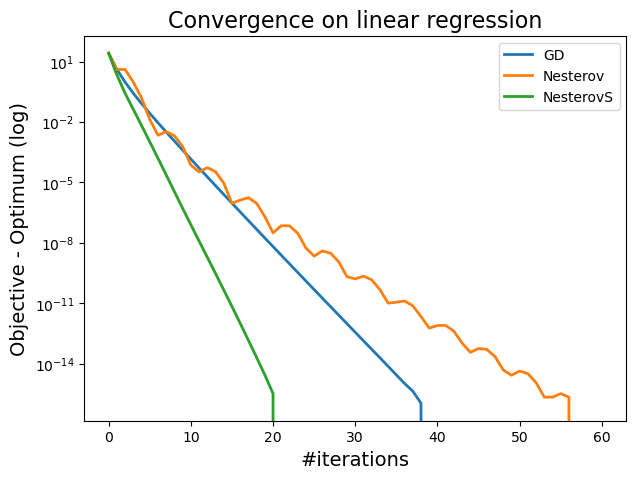

In [13]:
# Comparison of the two methods on the last run
# Remark: in log scale, the values close to 0 (below 10^{-14}) do not appear, or produce artifacts.
plt.figure(figsize=(7, 5))
plt.semilogy(obj_gd-f_min_lin, label="GD", lw=2)
plt.semilogy(obj_n-f_min_lin, label="Nesterov", lw=2)
plt.semilogy(obj_ns-f_min_lin, label="NesterovS", lw=2)
plt.title("Convergence on linear regression", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Objective - Optimum (log)", fontsize=14)
plt.legend()

### <span style="color:rgb(92,29,79)">Question 12</span>

*Comment on the results above. How can we explain that the function values for Nesterov's method are not monotonically decreasing?*

#### <span style="color:rgb(92,29,79)">Answer to question 12</span>

- The objective function at hand is strongly convex, hence Nesterov's method for *convex* functions is not the most efficient. On the other hand, Nesterov's method for *strongly convex* functions does outperform gradient descent.

- The theoretical guarantees for the stepsize $\alpha_k=\frac{1}{L}$ only hold for gradient descent. At every iteration, we have $f(\mathbf{w}_k)<f(\mathbf{z}_k)$, however we have no guarantee that $f(\mathbf{z}_{k+1})$ will be lower than $f(\mathbf{z}_k)$. Note that this does not prevent $f(\mathbf{z}_k)$ to converge.

In [ ]:
# Version 2.0 - C. W. Royer, October 2024.